In [37]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.gridspec import GridSpec
import seaborn as sns

# import data_clean_utils
from scipy.stats import chi2_contingency, f_oneway, jarque_bera, probplot
import plotly.express as px
import timeit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.exceptions import DataConversionWarning


warnings.filterwarnings("ignore")

# importlib.reload(data_clean_script)     # reload

In [2]:
import dagshub

dagshub.init(repo_owner="rabin20-04", repo_name="delivery_time_prediction", mlflow=True)

Accessing as rabin20-04

Initialized MLflow to track repo "rabin20-04/delivery_time_prediction"

Repository rabin20-04/delivery_time_prediction initialized!

In [ ]:
from sklearn import set_config

set_config(transform_output="pandas")

In [ ]:
original_df = pd.read_csv("../data/raw/train.csv")

import sys
import importlib

sys.path.append("../data/files_/")
import data_clean_script

# importlib.reload(data_clean_script)

In [5]:
df = data_clean_script.perform_data_cleaning(original_df)

In [6]:
df.shape

(45502, 19)

In [7]:
df.sample(6)

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
45495,24.0,5.0,windy,jam,2,drinks,electric_scooter,0.0,no,urban,17,PUNE,3,tuesday,0,10.0,night,10.723990,long
33190,28.0,4.6,cloudy,low,0,buffet,motorcycle,1.0,no,metropolitian,23,RANCHI,3,saturday,1,15.0,night,9.055477,medium
7726,24.0,4.8,cloudy,low,2,drinks,scooter,0.0,no,metropolitian,10,CHEN,3,tuesday,0,10.0,night,7.762547,medium
19818,24.0,4.6,windy,high,0,drinks,motorcycle,0.0,no,metropolitian,25,AGR,2,thursday,0,15.0,afternoon,5.952987,medium
13066,20.0,4.7,windy,low,2,buffet,scooter,0.0,no,metropolitian,15,RANCHI,3,thursday,0,15.0,morning,NaN,NaN
21032,38.0,4.8,cloudy,jam,0,meal,motorcycle,1.0,no,metropolitian,46,MUM,3,wednesday,0,15.0,night,16.824772,very_long


In [8]:
df.columns.tolist()

['age',
 'ratings',
 'weather',
 'traffic',
 'vehicle_condition',
 'type_of_order',
 'type_of_vehicle',
 'multiple_deliveries',
 'festival',
 'city_type',
 'time_taken',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'pickup_time_minutes',
 'order_time_of_day',
 'distance',
 'distance_type']

In [ ]:
df.drop(
    columns={"city_name", "order_day_of_week", "order_month"}, axis=1, inplace=True
)  # contains just two months data -- may lead to overfit

In [10]:
df.shape

(45502, 16)

In [11]:
df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(0)

# Exp - 1 drop missing


<Axes: >

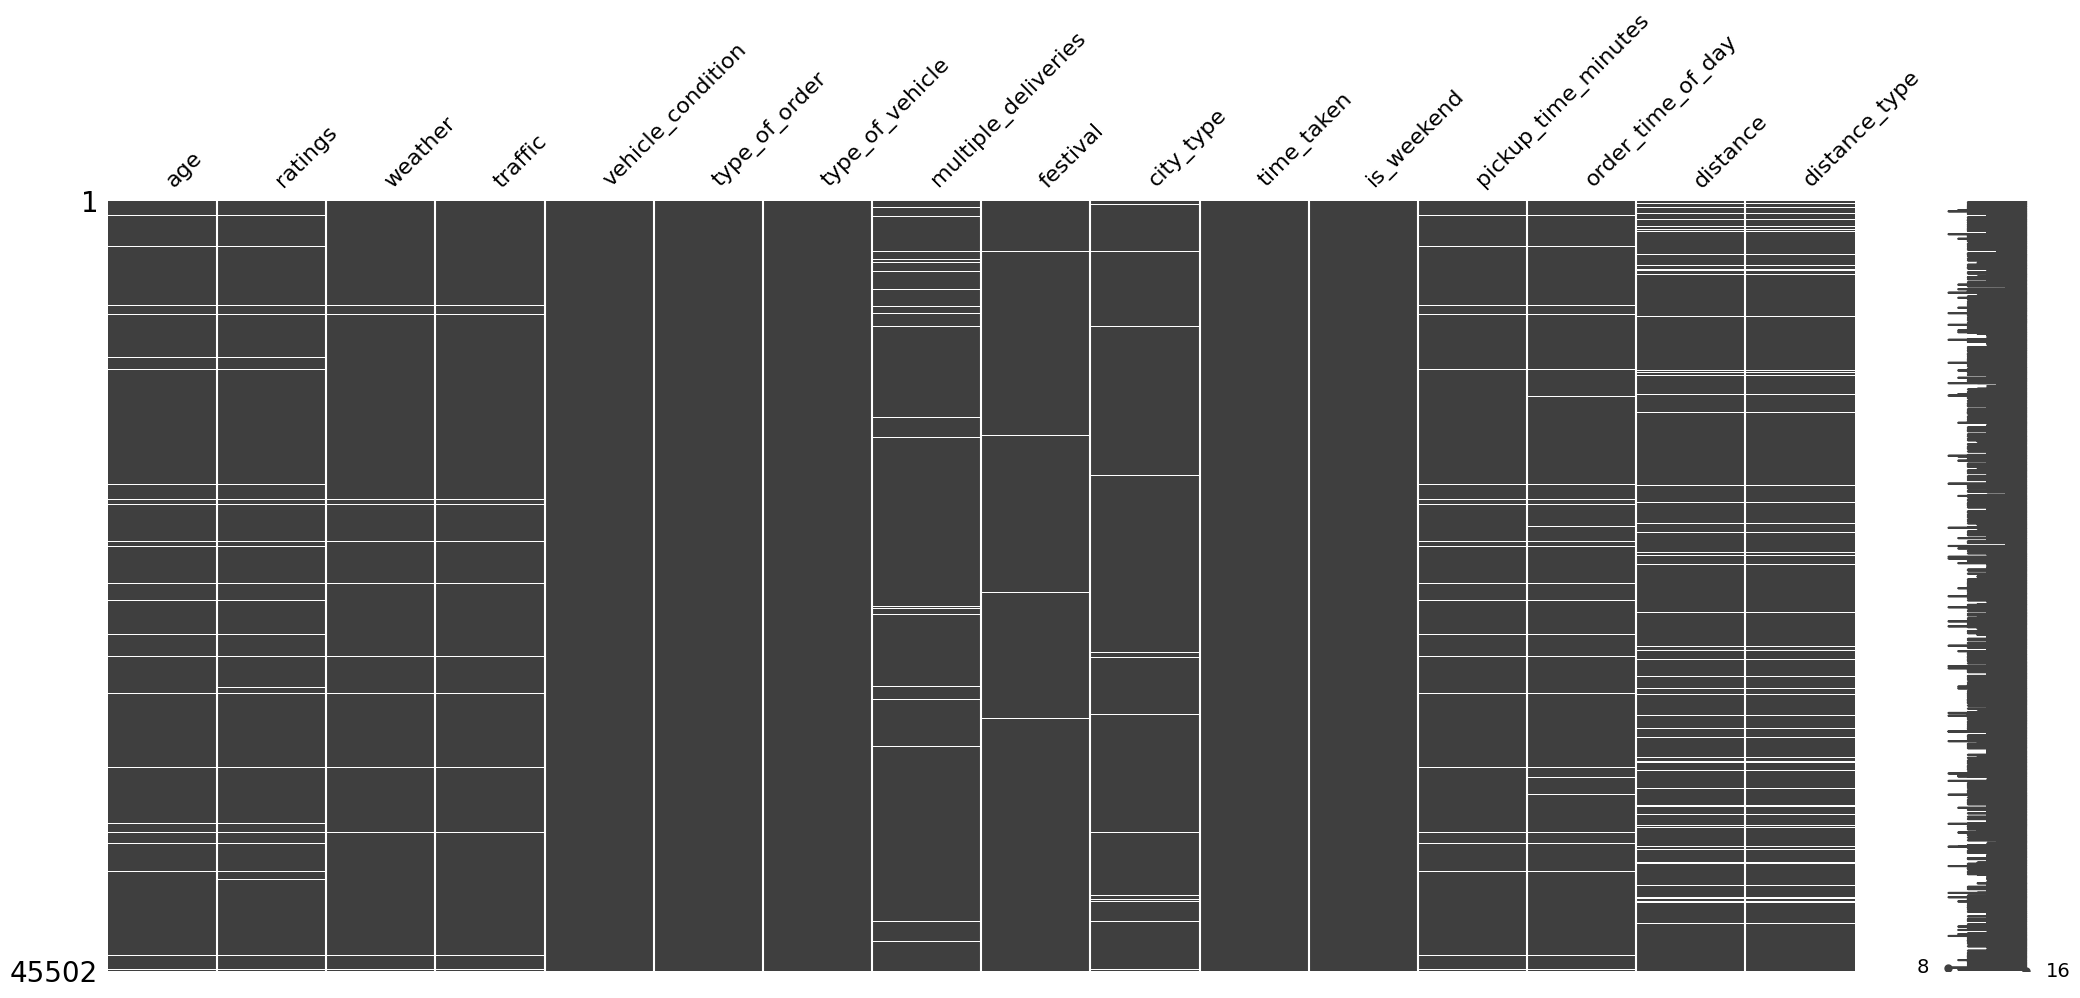

In [13]:
msno.matrix(df)

In [14]:
# Mnar

In [15]:
import mlflow

In [ ]:
mlflow.set_tracking_uri(
    "https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow"
)

In [17]:
mlflow.set_experiment("EXP-1  keep vs impute misisng values")

<Experiment: artifact_location='mlflow-artifacts:/49a29b2d29f64da7927eeaecdff19c67', creation_time=1751014708140, experiment_id='0', last_update_time=1751014708140, lifecycle_stage='active', name='EXP-1  keep vs impute misisng values', tags={}>

In [ ]:
temp_df = df.copy().dropna()

In [ ]:
X = temp_df.drop(columns="time_taken", axis=1)
y = temp_df["time_taken"]

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((30156, 15), (7539, 15), (30156,), (7539,))

In [28]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30156 entries, 8720 to 19002
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  30156 non-null  float64 
 1   ratings              30156 non-null  float64 
 2   weather              30156 non-null  object  
 3   traffic              30156 non-null  object  
 4   vehicle_condition    30156 non-null  int64   
 5   type_of_order        30156 non-null  object  
 6   type_of_vehicle      30156 non-null  object  
 7   multiple_deliveries  30156 non-null  float64 
 8   festival             30156 non-null  object  
 9   city_type            30156 non-null  object  
 10  is_weekend           30156 non-null  int64   
 11  pickup_time_minutes  30156 non-null  float64 
 12  order_time_of_day    30156 non-null  category
 13  distance             30156 non-null  float64 
 14  distance_type        30156 non-null  category
dtypes: category(2), float

## Preprocessing


In [33]:
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]
# continuous | categorical | nominal

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "order_time_of_day",
    "is_weekend",
]
ordinal_cat_cols = ["traffic", "distance_type"]
traffic_order = ["low", "medium", "high", "jam"]
distance_order = ["short", "medium", "long", "very_long"]

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[traffic_order, distance_order]),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=3,
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,3
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [ ]:
xtrain_transformed = preprocessor.fit_transform(xtrain)
xtest_transformed = preprocessor.transform(xtest)

In [36]:
xtrain.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
8720,29.0,3.9,sunny,jam,0,drinks,motorcycle,2.0,no,semi-urban,0,15.0,night,9.348069,medium
25245,39.0,4.4,sandstorms,medium,0,meal,motorcycle,1.0,no,metropolitian,1,5.0,afternoon,4.469606,short
34118,29.0,4.5,sunny,high,1,buffet,motorcycle,0.0,no,urban,0,10.0,morning,1.513073,short
26036,39.0,4.8,sandstorms,low,0,meal,motorcycle,1.0,no,metropolitian,1,15.0,night,10.445118,long
37194,30.0,4.4,windy,medium,1,buffet,scooter,1.0,no,metropolitian,1,10.0,afternoon,6.217834,medium


In [ ]:
pt = PowerTransformer()
ytrain_transformed = pt.fit_transform(ytrain.values.reshape(-1, 1))
ytest_transformed = pt.transform(ytest.values.reshape(-1, 1))
pt.lambdas_

array([0.32446095])

In [ ]:
rf = RandomForestRegressor()
rf.fit(xtrain_transformed, ytrain_transformed)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
ytrain_pred = rf.predict(xtrain_transformed)
ytest_pred = rf.predict(xtest_transformed)

In [ ]:
ytrain_pred = pt.inverse_transform(ytrain_pred.reshape(-1, 1))
ytest_pred = pt.inverse_transform(ytest_pred.reshape(-1, 1))

In [ ]:
print("MAE: Train error: ", mean_absolute_error(ytrain, ytrain_pred), "minutes")
print("MAE: Test error: ", mean_absolute_error(ytest, ytest_pred), "minutes")
print("-" * 5, "\nr2: Train score: ", r2_score(ytrain, ytrain_pred))
print("r2: Test score: ", r2_score(ytest, ytest_pred))

MAE: Train error:  1.1548403822883149 minutes
MAE: Test error:  3.0910199069344606 minutes
----- 
r2: Train score:  0.9754856274606626
r2: Test score:  0.8264377179605871


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf, xtrain_transformed, ytrain_transformed, cv=5, scoring="r2", n_jobs=4
)

In [54]:
scores

array([0.80825953, 0.81009847, 0.80991346, 0.80874977, 0.81230538])

In [55]:
scores.mean()

np.float64(0.8098653232380768)

In [56]:
# scores.mean() np.float64(0.8266552255635975) without PowerTransformer

<Axes: >

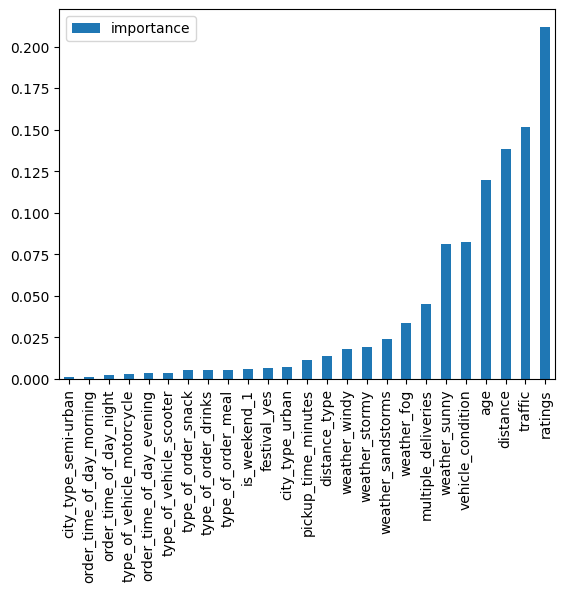

In [ ]:
pd.DataFrame(
    rf.feature_importances_, index=xtrain_transformed.columns, columns=["importance"]
).sort_values(by="importance").plot(kind="bar")

In [ ]:
pd.DataFrame(
    rf.feature_importances_, index=xtrain_transformed.columns, columns=["importance"]
).sort_values(by="importance")

,importance
city_type_semi-urban,0.000829
order_time_of_day_morning,0.001148
order_time_of_day_night,0.002236
type_of_vehicle_motorcycle,0.003052
order_time_of_day_evening,0.003295
type_of_vehicle_scooter,0.003461
type_of_order_snack,0.005351
type_of_order_drinks,0.005410
type_of_order_meal,0.005426
is_weekend_1,0.005793


In [71]:
# log Experiment
import mlflow.experiments


with mlflow.start_run(run_name="Missing values dropped"):
    mlflow.log_param("experiment_type", "Missing values dropped ")

    # log model param
    mlflow.log_params(rf.get_params())

    # log metrices
    mlflow.log_metric("training error", mean_absolute_error(ytrain, ytrain_pred))
    mlflow.log_metric("test error : ", mean_absolute_error(ytest, ytest_pred))
    mlflow.log_metric("Train r2_score: ", r2_score(ytrain, ytrain_pred))
    mlflow.log_metric("Test r2_score: ", r2_score(ytest, ytest_pred))

🏃 View run Missing values dropped at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0/runs/5d9bca1984684a3b884775b0300de660
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0
